# Exercise 8.4

<p style="text-align: justify;">
The exploration bonus actually changes the estimated values of states and actions. Is this necessary? Suppose the bonus $\kappa \sqrt{\tau}$ was used not in updates, but solely in action selection. That is, suppose the action selected was always that for which $Q(S_{t}, a) + \kappa \sqrt{\tau(S_{t}, a)}$ was maximal. Carry out a gridworld experiment that tests and illustrates the strengths and weaknesses of this alternate approach.
</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from IPython.display import Image
from pprint import pprint
from tqdm import tqdm

%matplotlib inline

### General Settings

In [2]:
MAZE_ROWS = 6
MAZE_COLS = 9

ALPHA   = 1.00  # 0.10
EPSILON = 0.10 
GAMMA   = 0.95 
KAPPA   = 0.00 

N    = 5
RUNS = 100  # 10

ALL_STATES = {
    (row, col)
    for row in range(MAZE_ROWS)
    for col in range(MAZE_COLS)
}

ALL_ACTIONS = {
    (-1,  0),  # Down
    ( 0, -1),  # Left
    ( 0,  1),  # Right
    ( 1,  0),  # Up
#     (-1, -1),  # Down-left
#     (-1,  1),  # Down-right
#     ( 1, -1),  # Up-left
#     ( 1,  1)   # Up-right
}

START_STATES = {
    (0, 3)
}

GOAL_STATES = {
    (5, 8)
}

WALL_STATES = {
    (2, y) for y in range(1, 8)
}

MODEL_TYPES = [
    'Dyna-Q',
    'Dyna-Q+',
    'Dyna-Q+ modified'
]

# Initialize rewards
R = {
    state: 0
    for state in ALL_STATES
}

for state in GOAL_STATES:
    R[state] = 1

### Functions

In [3]:
def get_best_action(Q_s, t=0, T_s=None):
    best_value = -np.inf
    best_actions = []
    
    for a in Q_s.keys():
        action_value = Q_s[a]
        
        if T_s is not None:
            action_value += KAPPA * np.sqrt(t - T_s[a])

        if best_value < action_value:
            best_value = action_value
            best_actions = [a]
        elif best_value == action_value:
            best_actions += [a]
            
    return random.choice(best_actions)

In [4]:
def get_rts(mazes):
    return {
        model: np.vstack([maze['Rt'].cumsum()
                          for maze in mazes[model]]).mean(axis=0)
        for model in MODEL_TYPES
    }

In [5]:
def plot_models(mazes):
    Rts = get_rts(mazes)
    
    max_value = np.hstack([Rts[model]
                           for model in MODEL_TYPES]).max()
    
#     pprint(Rts)
    
    plt.figure(figsize=(9, 6))
    for model in MODEL_TYPES:
        plt.plot(Rts[model])
    plt.vlines(CHANGE_STATE, ymin=0, ymax=max_value,
               colors='gray', linestyles='dashed')
    plt.legend(MODEL_TYPES)
    plt.show()
    
    return

In [6]:
def initialize():
    M = dict()  # Model
    Q = dict()  # State-Action value
    T = dict()  # Timestamps
    
    for s in ALL_STATES:
        Q.setdefault(s, dict())
        T.setdefault(s, dict())
        
        for a in ALL_ACTIONS:
            # Initialize state-action values
            Q[s][a] = 0
            
            # Initialize timestamps
            T[s][a] = 0

    return {
        'M': M,
        'Q': Q,
        'T': T,
        'Rt': np.zeros(0)  # Rewards per time step
    }

In [7]:
def iterate(maze, model, change_time, total_iters, n=N):
    """
    model: {'Dyna-Q', 'Dyna-Q+', 'Dyna-Q+ modified'}
    iters_1: number of iterations in the "1st" part of the experiment
    iters_2: number of iterations in the "2nd" part of the experiment
    """
    if model not in MODEL_TYPES:
        print(f'ERROR: Model type \'{model}\' unknown!')
        return maze
    
    # Load varialbes
    M = maze['M']
    Q = maze['Q']
    T = maze['T']
    
    # Create new array of rewards per time step
    Rt = np.zeros(total_iters)
    
    WALL = WALL_BEFORE
    
    # Initialize start state
    s = random.choice(list(START_STATES))

    for t in range(total_iters):
        
        # Choose an action
        a = get_best_action(Q[s])
        if model == 'Dyna-Q+ modified':
            a = get_best_action(Q[s], t, T[s])
        elif np.random.uniform(low=0.0, high=1.0) < EPSILON:
            a = random.choice(list(ALL_ACTIONS))
        
        # Take the chosen action
        s_ = (s[0] + a[0], s[1] + a[1])

        # If out of bounds or hit a wall, stay in the same state
        if s_ not in ALL_STATES or s_ in WALL:
            s_ = s

        # Get a reward for the latest transition
        r = R[s_]
        Rt[t] = r

        # Update state-action value
        a_ = get_best_action(Q[s_])
        if model == 'Dyna-Q+ modified':
            a_ = get_best_action(Q[s_], t, T[s_])

        Q[s][a] += ALPHA * (r + GAMMA * Q[s_][a_] - Q[s][a])

        # Initialize state in the environment model
        if model == 'Dyna-Q':
            M.setdefault(s, dict())
        else:  # if model in {'Dyna-Q+', 'Dyna-Q+ modified'}
            if s not in M.keys():
                M[s] = dict()
                for a_ in ALL_ACTIONS:
                    M[s][a_] = (0, s)
                    T[s][a_] = 0
                
        # Store reward and new state in the model
        M[s][a] = (r, s_)
        
        # Update timestamp for the current state-action pair
        T[s][a] = t

        # Store next state
        next_s = s_
            
        # Planning
        for _ in range(n):
            
            # Pick a previously observed state
            s = random.choice(list(M.keys()))
            a = random.choice(list(M[s].keys()))
            r, s_ = M[s][a]

            # Update state-action value
            a_ = get_best_action(Q[s_])

            if model == 'Dyna-Q+':
                r += KAPPA * np.sqrt(t - T[s][a])
            if model == 'Dyna-Q+ modified':
                a_ = get_best_action(Q[s_], t, T[s_])

            Q[s][a] += ALPHA * (r + GAMMA * Q[s_][a_] - Q[s][a])
            
        # Make the next state a current state
        s = next_s
        
        # If a goal state has been reached
        if s in GOAL_STATES:
            
            # Start anew
            s = random.choice(list(START_STATES))
            
            # Change wall settings at beginning of a new episode
            if t >= change_time:
                WALL = WALL_AFTER

        
    return {
        'M': M,
        'Q': Q,
        'T': T,
        'Rt': np.hstack([maze['Rt'], Rt])
    }

In [8]:
def run():
    mazes = dict()

    for model in MODEL_TYPES:
        mazes[model] = []

        for _ in tqdm(range(RUNS)):
            maze = initialize()
            maze = iterate(maze, model, CHANGE_STATE, TOTAL_STATES)

            mazes[model] += [maze]

    plot_models(mazes)
    
    return mazes

## Example 8.2: Blocking Maze

<p style="text-align: justify;">
Initially, there is a short path from start to goal, to the right of the barrier, as shown in the upper left of the figure. After 1000 time steps, the short path is “blocked,” and a longer path is opened up along the left-hand side of the barrier, as shown in upper right of the figure. The graph shows average cumulative reward for a Dyna-Q agent and an enhanced Dyna-Q+ agent. When the environment changed, the graphs become flat, indicating a period during which the agents obtained no reward because they were wandering around behind the barrier. After a while, however, they were able to find the new opening and the new optimal behavior.
</p>    
<p style="text-align: justify;">
Greater difficulties arise when the environment changes to become better than it was before, and yet the formerly correct policy does not reveal the improvement. In these cases the modeling error may not be detected for a long time, if ever.
</p>    

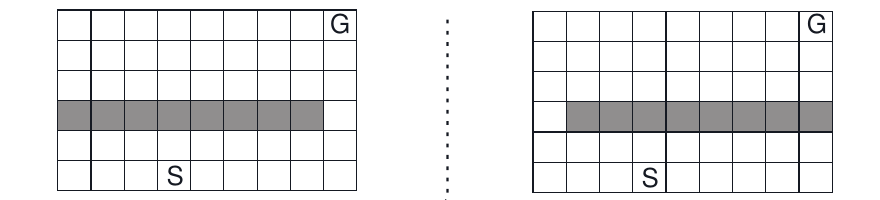

In [9]:
Image('ch08_ex04/example02.png', width=600)

#### Iterate

100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


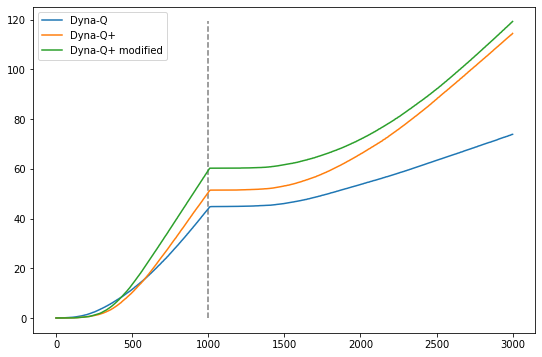

In [10]:
WALL_BEFORE = WALL_STATES.union({(2, 0)})
WALL_AFTER  = WALL_STATES.union({(2, 8)})

CHANGE_STATE = 1000
TOTAL_STATES = 3000

KAPPA = 1e-4
N     = 10

m1 = run()

## Example 8.3: Shortcut Maze

<p style="text-align: justify;">
Initially, the optimal path is to go around the left side of the barrier (upper left). After 3000 steps, however, a shorter path is opened up along the right side, without disturbing the longer path (upper right). The graph shows that the regular Dyna-Q agent never switched to the shortcut. In fact, it never realized that it existed. Its model said that there was no shortcut, so the more it planned, the less likely it was to step to the right and discover it. Even with an $\epsilon$-greedy policy, it is very unlikely that an agent will take so many exploratory actions as to discover the shortcut.
</p>

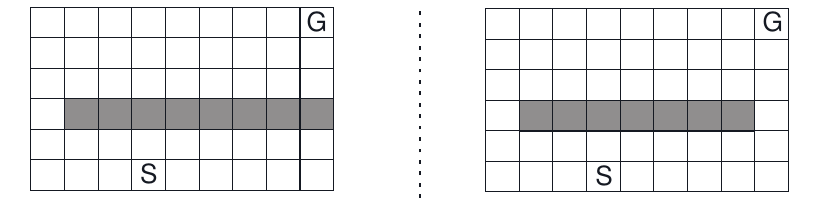

In [11]:
Image('ch08_ex04/example03.png', width=600)

100%|██████████| 100/100 [00:55<00:00,  1.75it/s]


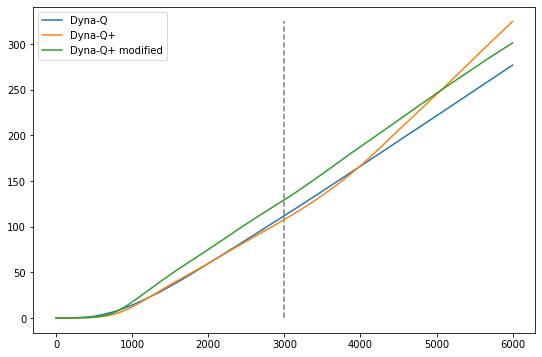

In [12]:
WALL_BEFORE = WALL_STATES.union({(2, 8)})
WALL_AFTER  = WALL_STATES

CHANGE_STATE = 3000
TOTAL_STATES = 6000

KAPPA = 1e-3
N     = 50

m2 = run()

## Conclusion

<p style="text-align: justify;">
The modified Dyna-Q+ algorithm can exploit better once the optimal policy has been found, but it cannot adapt to environmental changes as fast as the Dyna-Q+ algorithm can.
</p>